In [1]:
import torch
import numpy as np
import pandas as pd

/home/raquelpanadero/Desktop/TFG/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('/home/raquelpanadero/Desktop/TFG/scripts')

from utils import create_dataloaders
from models.bb_encoder_decoder import BBEncoderDecoder
from models.bb_crops_encoder_decoder import BBCropsEncoderDecoder
from evaluation.evaluate import save_results, get_results
from evaluation.bb_crops_ed import save_bb_crops_ed_results
from visualization import plot_frames, plot_mean_metric

## Initialize

In [3]:
data = torch.load('/home/raquelpanadero/Desktop/TFG/waymo_dataset_images/dataset.pt')

input_size = 8
output_size = 4
target_len = 9
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### BB E-D

In [ ]:
# define the net
batch_size = 512
hidden_size = 64
num_layers = 2

train_loader, valid_loader, test_loader = create_dataloaders(data, batch_size=batch_size)

bb_net = BBEncoderDecoder(
    input_size=input_size,
    output_size=output_size, 
    batch_size=batch_size, 
    target_len=target_len, 
    hidden_size=hidden_size,
    num_layers=num_layers,
    device=device
)
bb_net.load_state_dict(torch.load('/home/raquelpanadero/Desktop/TFG/trained_models/best_bb_encoder_decoder.pt'))
bb_net.to(device)
bb_net.eval()

### BB+Crops E-D

In [ ]:
# define the net
batch_size = 16
hidden_size = 512
num_layers = 1

bb_crops_net = BBCropsEncoderDecoder(
    input_size=input_size,
    output_size=output_size, 
    batch_size=batch_size, 
    target_len=target_len, 
    hidden_size=hidden_size,
    num_layers=num_layers,
    device=device
) 
bb_crops_net.load_state_dict(
    torch.load('/home/raquelpanadero/Desktop/TFG/trained_models/dino_finetuning=True_normlayer=False.pt')
)
bb_crops_net.to(device)
bb_crops_net.eval()

### SAVE RESULTS

In [4]:
root_path = '/home/raquelpanadero/Desktop/TFG/results'

In [ ]:
save_results(
    bb_net=bb_net, 
    bb_crops_net=bb_crops_net, 
    data=data, 
    device=device, 
    root_path=root_path
)

In [ ]:
results = get_results(root_path)
results

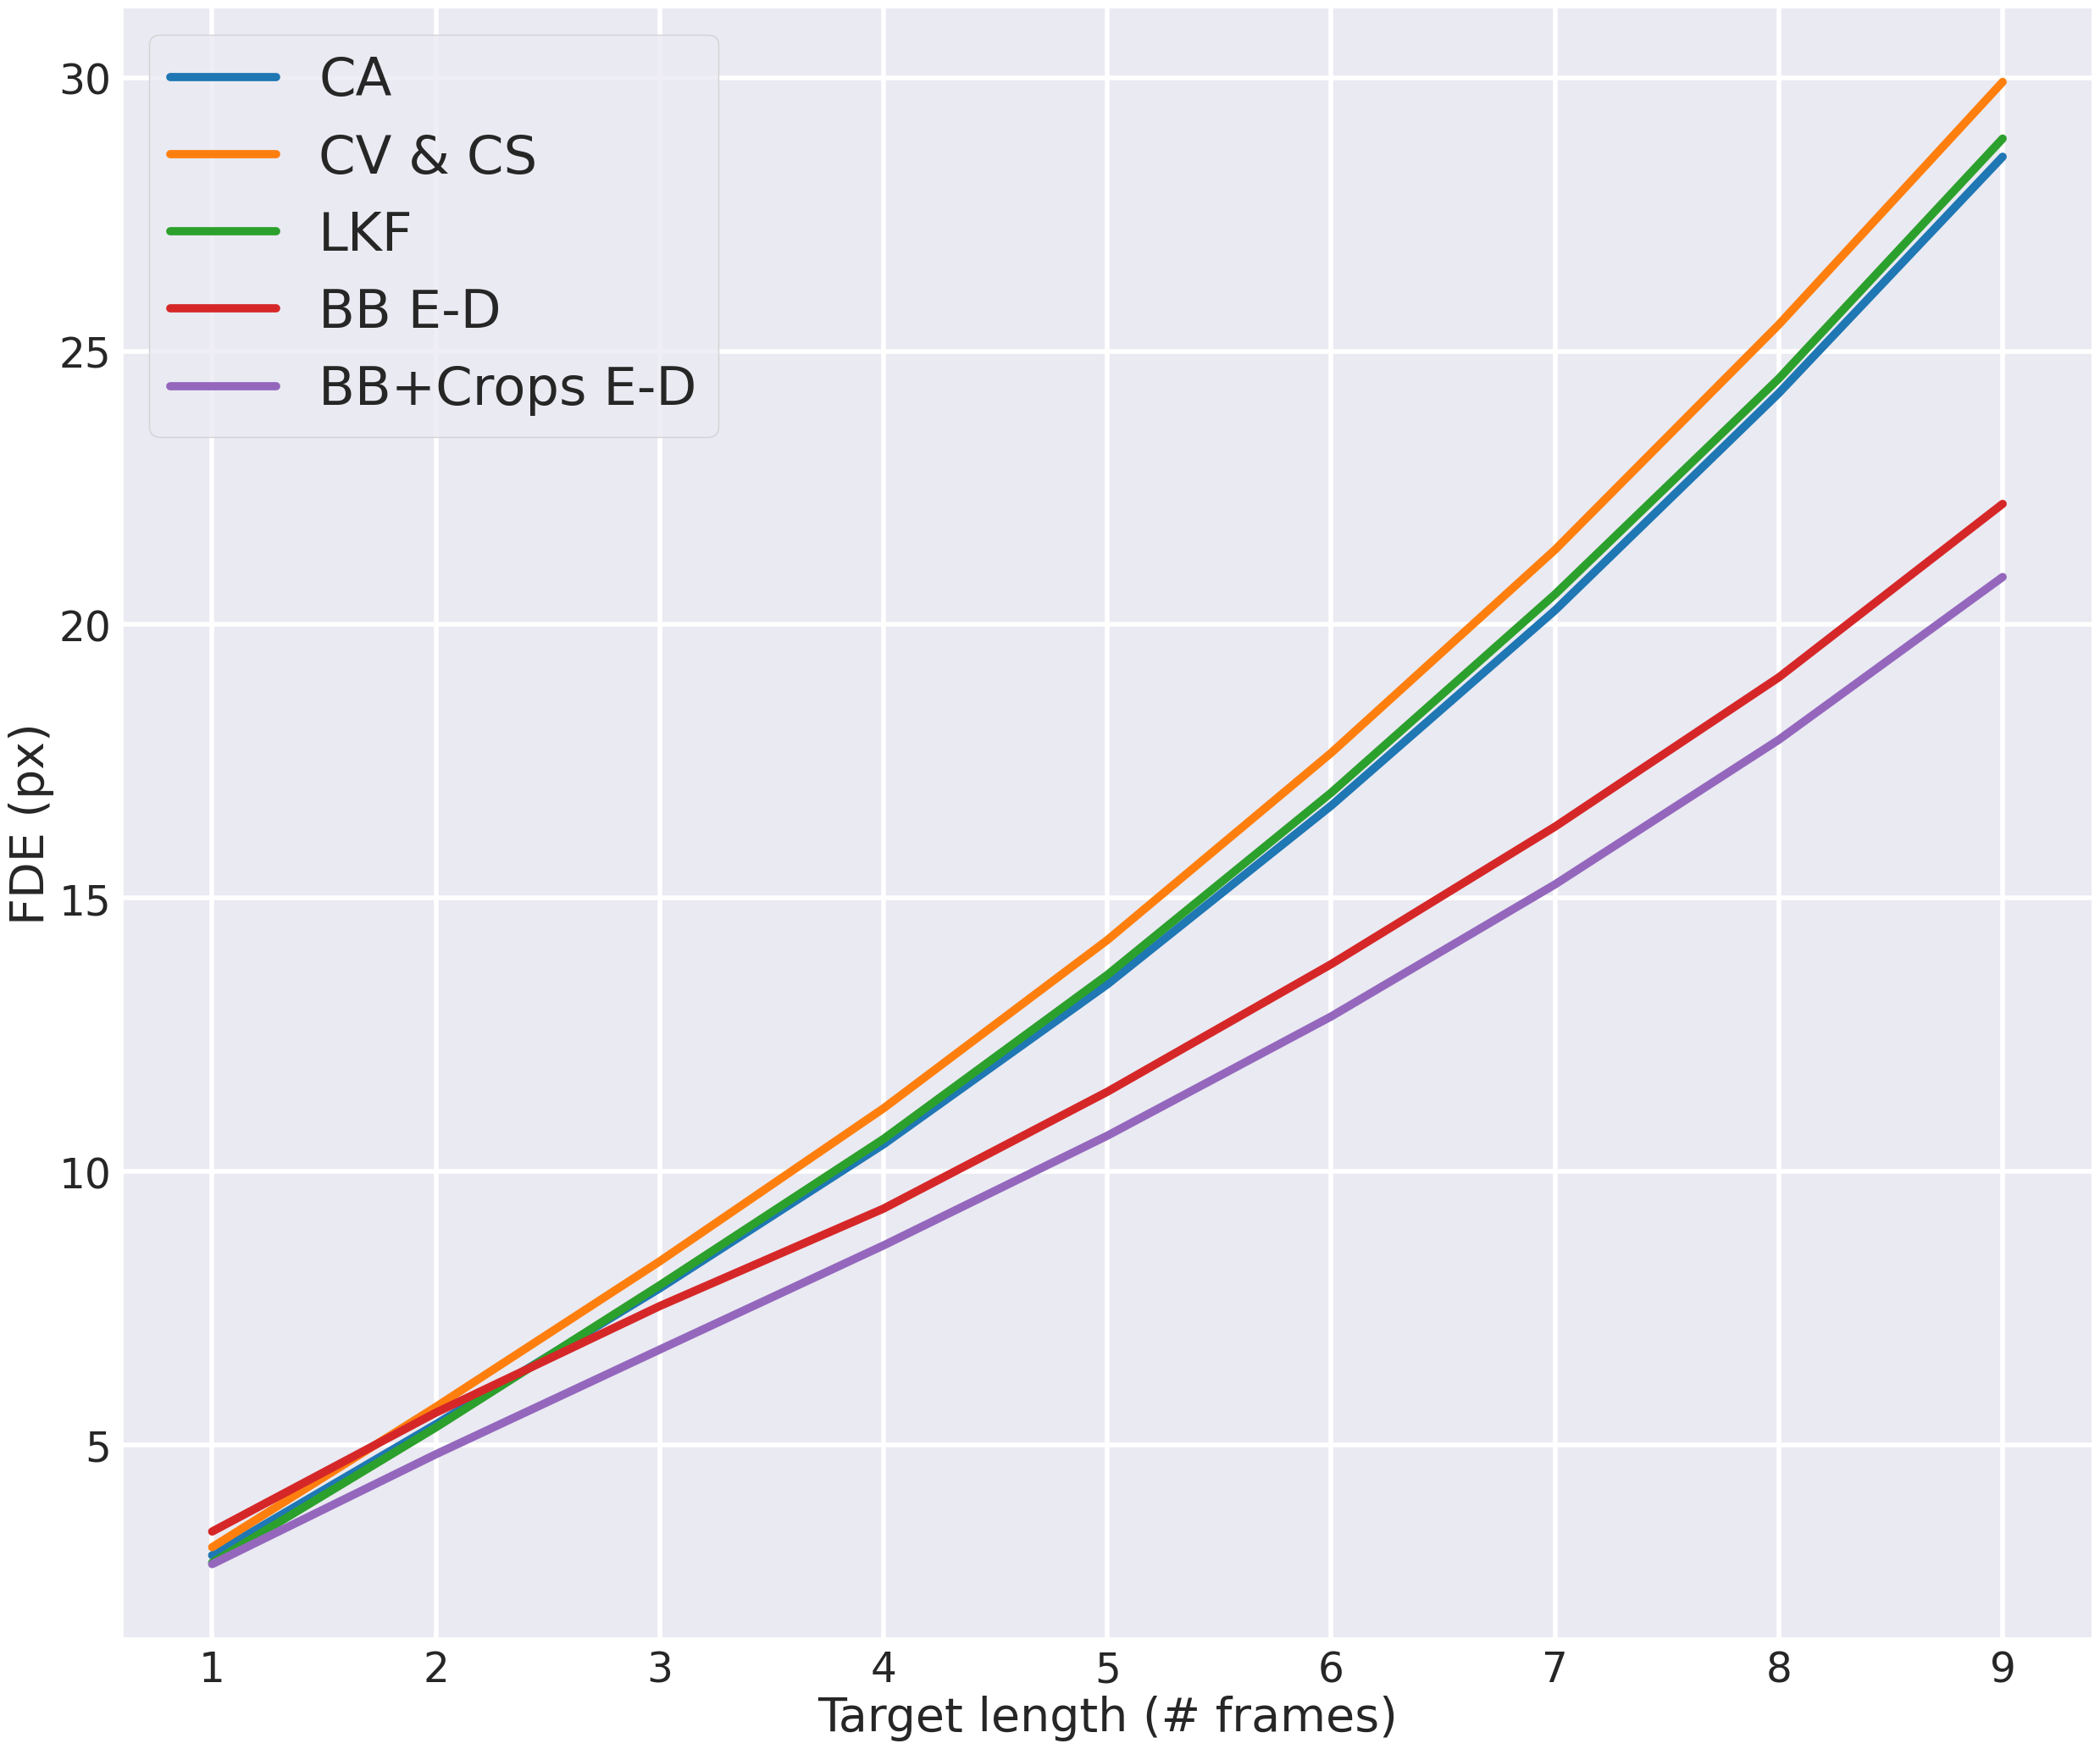

In [79]:
plot_mean_metric(metric='fde', set='test', root_path=root_path)

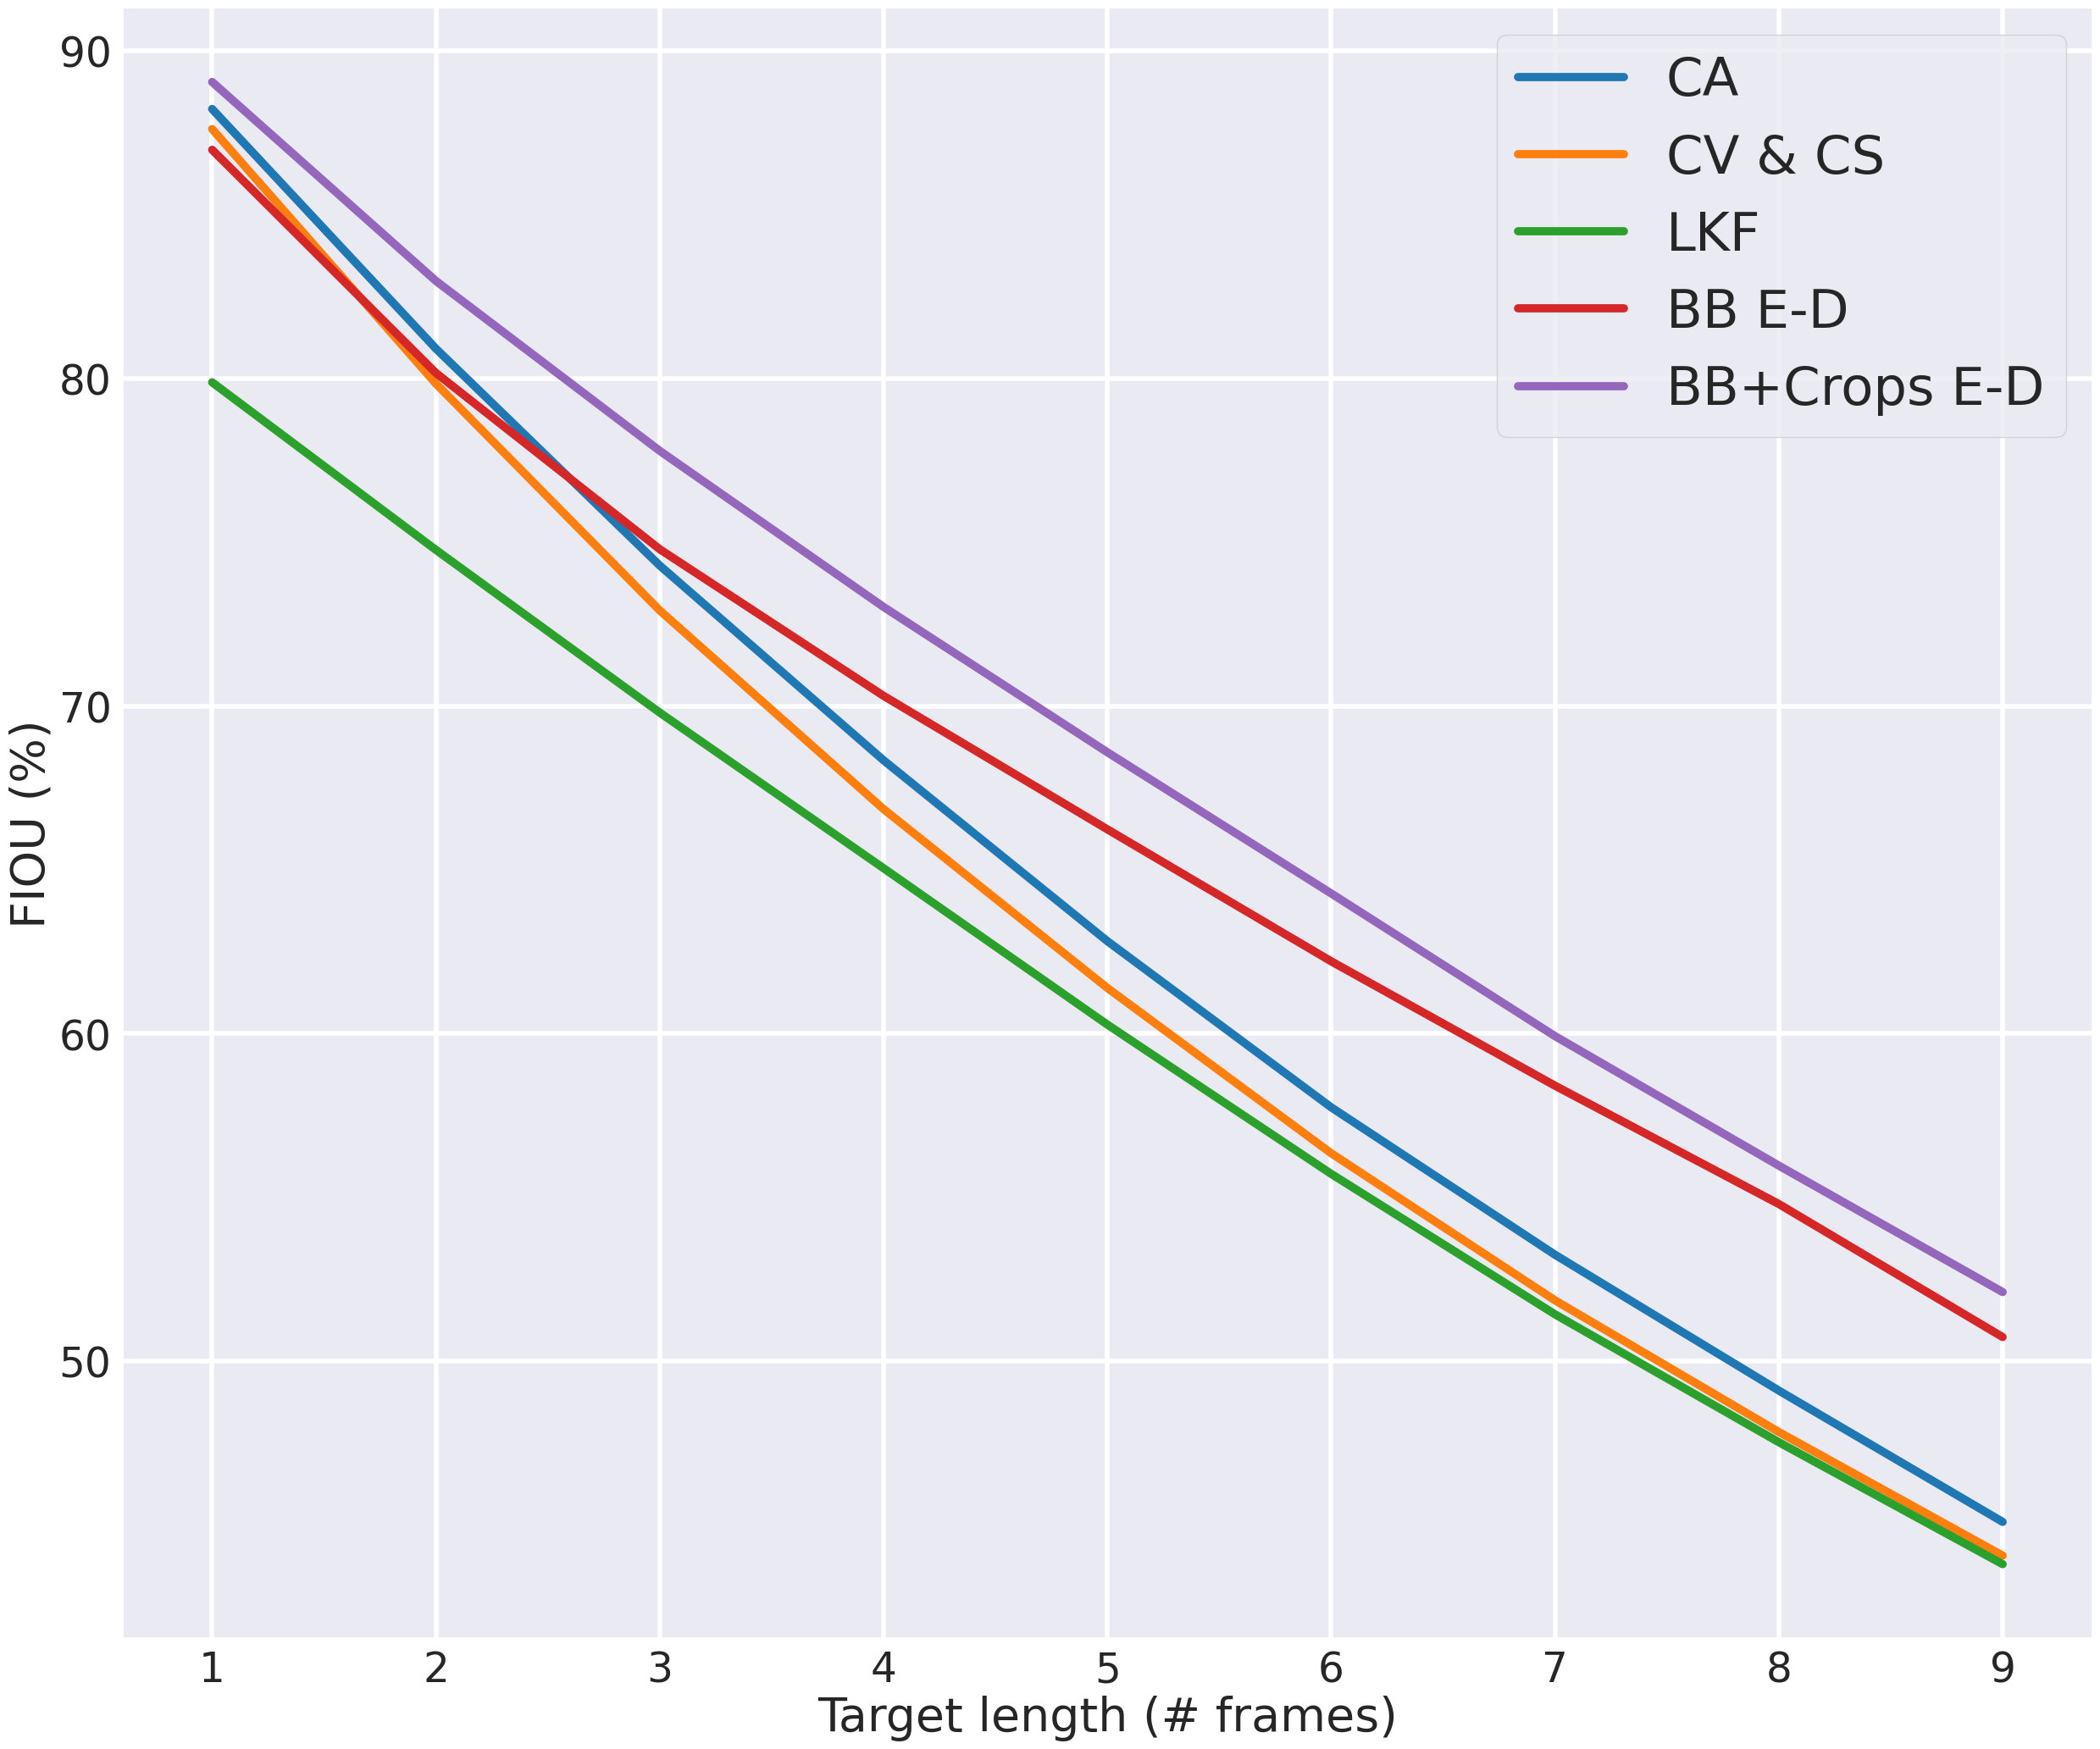

In [80]:
plot_mean_metric(metric='fiou', set='test', root_path=root_path)

### PLOT PREDICTED FRAMES

In [91]:
element = next(iter(train_loader))

In [ ]:
plot_frames(element, bb_net, bb_crops_net, device, 1)

## OTHER MODELS

In [ ]:
batch_size = 16
hidden_size = 512
num_layers = 1

models = ['dino', 'vgg', 'resnet']
normalization_layers = [False, True]
finetuning = [False, True]


paths = [
    'dino_finetuning=False_normlayer=False.pt',
    'dino_finetuning=True_normlayer=False.pt',
    'dino_finetuning=False_normlayer=True.pt',
    'dino_finetuning=True_normlayer=True.pt',
    'vgg_finetuning=False_normlayer=False.pt',
    'vgg_finetuning=True_normlayer=False.pt',
    'vgg_finetuning=False_normlayer=True.pt',
    'vgg_finetuning=True_normlayer=True.pt',
    'resnet_finetuning=False_normlayer=False.pt',
    'resnet_finetuning=True_normlayer=False.pt',
    'resnet_finetuning=False_normlayer=True.pt',
    'resnet_finetuning=True_normlayer=True.pt'
    
]
root_path = '/home/raquelpanadero/Desktop/TFG/results'

train_loader, valid_loader, test_loader = create_dataloaders(data, batch_size=batch_size)

i = 0
for model in models:
    for nlayer in normalization_layers:
        for ft in finetuning:
            net = BBCropsEncoderDecoder(
                input_size=input_size,
                output_size=output_size, 
                batch_size=batch_size, 
                target_len=target_len, 
                hidden_size=hidden_size,
                num_layers=num_layers,
                device=device,
                feat_extractor = model,
                fine_tuning = ft,
                normalization_layers = nlayer
            )
            net.load_state_dict(torch.load(f'/home/raquelpanadero/Desktop/TFG/trained_models/{model}/{paths[i]}'))
            net.to(device)
            net.eval()
            
            csv_path = f'{root_path}/{model}_ft={ft}_normlayer={nlayer}_%s.csv'
            save_bb_crops_ed_results(net, train_loader, device, csv_path % 'train')
            save_bb_crops_ed_results(net, test_loader, device, csv_path % 'test')
            save_bb_crops_ed_results(net, valid_loader, device, csv_path % 'valid')
            
            i += 1

In [ ]:
results = {}
methods = [
    'dino_ft=False_normlayer=False', 'dino_ft=True_normlayer=False', 'dino_ft=False_normlayer=True', 'dino_ft=True_normlayer=True',
    'resnet_ft=False_normlayer=False', 'resnet_ft=True_normlayer=False', 'resnet_ft=False_normlayer=True', 'resnet_ft=True_normlayer=True',
    'vgg_ft=False_normlayer=False', 'vgg_ft=True_normlayer=False', 'vgg_ft=False_normlayer=True', 'vgg_ft=True_normlayer=True',
]
sets = ['train', 'valid', 'test']
for method in methods:
    print(f'\n{method}\n')
    for set in sets:
        csv_path = f'{root_path}/{method}_{set}.csv'
        df = pd.read_csv(csv_path)
        metrics = df.describe()

        res = {
            set: {
                'fde_0': np.around(metrics['fde_0']['mean'], 2),
                'ade': np.around(metrics['ade']['mean'], 2),
                'fde_8': np.around(metrics['fde_8']['mean'], 2),
                'fiou_0': np.around(metrics['fiou_0']['mean'], 2),
                'aiou': np.around(metrics['aiou']['mean'], 2),
                'fiou_8': np.around(metrics['fiou_8']['mean'], 2)
            }
        }
        print(res)

        if method in results:
            results[method].update(res)
        else:
            results[method] = res
